In [98]:
from collections import Counter
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import (SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC,
                                    KMeansSMOTE)
from imblearn.over_sampling import RandomOverSampler
from imblearn.base import BaseSampler
from fastai import *
from fastai.vision import *

In [70]:
def create_dataset(n_samples=1000, weights=(0.01, 0.01, 0.98), n_classes=3,
                   class_sep=0.8, n_clusters=1):
    return make_classification(n_samples=n_samples, n_features=1
                               n_informative=1 n_redundant=0, n_repeated=0,
                               n_classes=n_classes,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, random_state=0)

In [104]:
path = datapath4file('306_kaggle')
tfms = get_transforms()
data = (ImageList.from_folder(path)
        .split_by_rand_pct(valid_pct=0.2)
        .label_from_folder()
        .transform(tfms, size=48)
        .databunch()).normalize(imagenet_stats)

print('train set: ' + str(len(data.train_ds)))
print('valid set: ' + str(len(data.valid_ds)))

train set: 30424
valid set: 7605


In [132]:
print(str(data.train_ds[0][0].shape))
# print(
#     str(
#         data.train_ds[0][0].shape.reshape(
#             (data.train_ds[0][0].shape[0], data.train_ds[0][0].shape[1] *data.train_ds[0][0].shape[1]
#                                     )
#      )

torch.Size([3, 48, 48])


In [169]:
names = []
shapes = []
anger, happiness, sadness, neutral, disgust, fear, surprise = 0, 0, 0, 0, 0, 0, 0

for i in data.train_ds:
    # get the Image tensor to numpy array
    my_tensor = i[0].data.cpu().detach().numpy()
    # get batch, line, cols of the array
    batch, line, cols = my_tensor.shape
    # reshape
    to_be_used_in_resample = my_tensor.reshape(batch,-1)
    # append the reshaped numpy array 
    shapes.extend(to_be_used_in_resample)
    names.append(str(i[1]))
    if str(i[1]) == 'surprise':
        surprise += 1
    if str(i[1]) == 'neutral':
        neutral += 1
    if str(i[1]) == 'anger':
        anger += 1
    if str(i[1]) == 'disgust':
        disgust += 1
    if str(i[1]) == 'fear':
        fear += 1
    if str(i[1]) == 'happiness':
        happiness += 1
    if str(i[1]) == 'sadness':
        sadness += 1
        
print('TRAIN SET')        
print('anger: ' + str(anger))
print('disgust: ' + str(disgust))
print('fear: ' + str(fear))
print('happiness: ' + str(happiness))
print('neutral: ' + str(neutral))
print('sadness: ' + str(sadness))
print('surprise: ' + str(surprise))
    

TRAIN SET
anger: 4197
disgust: 690
fear: 4339
happiness: 7469
neutral: 5187
sadness: 5102
surprise: 3440


In [3]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

In [4]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

In [5]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

ValueError: Found input variables with inconsistent numbers of samples: [91272, 30424]

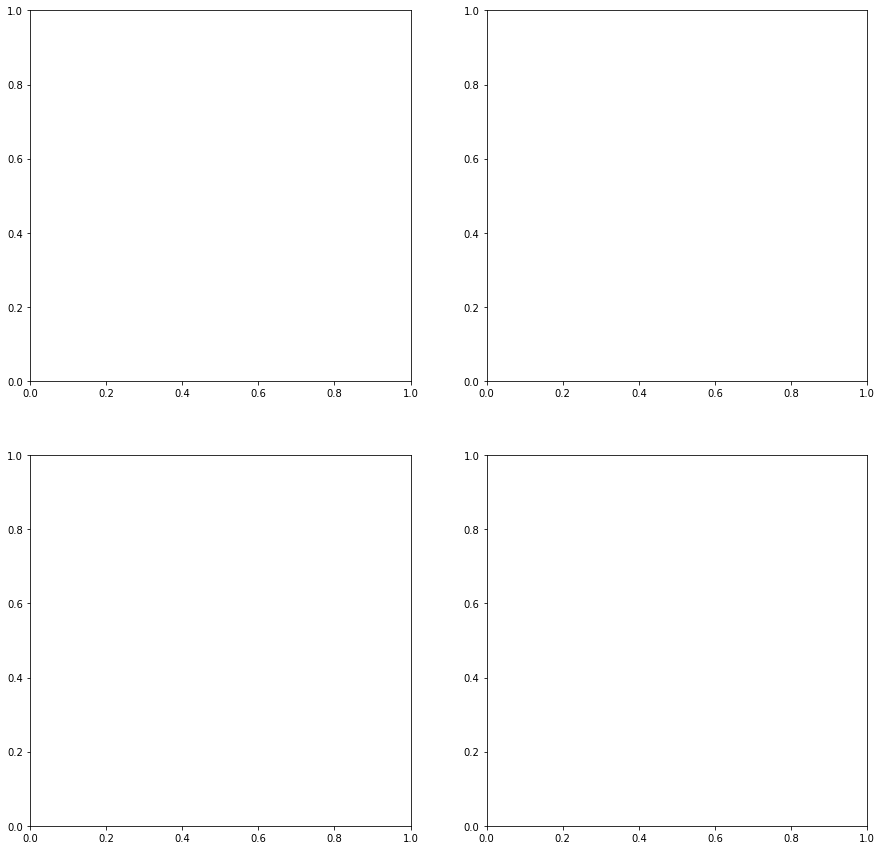

In [170]:
# Make an identity sampler
class FakeSampler(BaseSampler):

    _sampling_type = 'bypass'

    def _fit_resample(self, X, y):
        return X, y

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

X, y = shapes, names 
sampler = FakeSampler()
clf = make_pipeline(sampler, LinearSVC())
plot_resampling(X, y, sampler, ax1)
ax1.set_title('Original data - y={}'.format(Counter(y)))

ax_arr = (ax2, ax3, ax4)
for ax, sampler in zip(ax_arr, (RandomOverSampler(random_state=0),
                                SMOTE(random_state=0),
                                ADASYN(random_state=0))):
    clf = make_pipeline(sampler, LinearSVC())
    clf.fit(X, y)
    plot_resampling(X, y, sampler, ax)
    ax.set_title('Resampling using {}'.format(sampler.__class__.__name__))
fig.tight_layout()